In [15]:
!pip install --upgrade pip
!pip install pandas
!pip install pillow
!pip install tensorflow


import sys
import os
import zipfile
import warnings;
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report


#local_zip = 'BaseFotos.zip'
#zip_ref = zipfile.ZipFile(local_zip, 'r')
#zip_ref.extractall('')
#zip_ref.close()

base_dir = 'BaseFotos'
train_dir = os.path.join(base_dir, 'training')
test_dir = os.path.join(base_dir, 'test')


# Directory with our training arritmia pictures
train_arritmia_dir = os.path.join(train_dir, 'Arritmia')

# Directory with our training normal pictures
train_normal_dir = os.path.join(train_dir, 'Normal')

# Directory with our validation arritmia pictures
test_arritmia_dir = os.path.join(test_dir, 'Arritmia')

# Directory with our validation normal pictures
test_normal_dir = os.path.join(test_dir, 'Normal')

train_arritmia_fnames = os.listdir(train_arritmia_dir)
print(train_arritmia_fnames[:10])

train_normal_fnames = os.listdir(train_normal_dir)
train_normal_fnames.sort()
print(train_normal_fnames[:10])


# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0





['0001Lpat_109.png', '0001Lpat_111.png', '0001Lpat_207.png', '0001Lpat_214.png', '0002Apat_112.png', '0002Apat_113.png', '0002Apat_114.png', '0002Apat_118.png', '0002Apat_124.png', '0002Apat_200.png']
['0002Npat_210 - copia.png', '0002Npat_210.png', '0002Npat_212 - copia.png', '0002Npat_212.png', '0002Npat_213 - copia.png', '0002Npat_213.png', '0002Npat_215 - copia.png', '0002Npat_215.png', '0002Npat_219 - copia.png', '0002Npat_219.png']


In [16]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 1
next_arritmia_pix = [os.path.join(train_arritmia_dir, fname) 
                for fname in train_arritmia_fnames[pic_index-4:pic_index]]
next_normal_pix = [os.path.join(train_normal_dir, fname) 
                for fname in train_normal_fnames[pic_index-4:pic_index]]

for i, img_path in enumerate(next_arritmia_pix+next_normal_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Our input feature map is 400x900x3: 400x900 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(250, 250, 3))

# First convolution extracts 16 filters that are 3x3 modificado a 32
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)


# Add a dropout rate of 0.5
x = layers.Dropout(0.30)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)


model.summary()


model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.005),
              metrics=['acc'])


# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=1,
    width_shift_range=0,
    height_shift_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=False,)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(250, 250),  # All images will be resized to 150x150
        batch_size=15,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(250, 250),
        batch_size=15,
        class_mode='binary')


<Figure size 1152x1152 with 0 Axes>

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 248, 248, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 124, 124, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 122, 122, 32)      4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 59, 59, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 29, 29, 64)        0  

Epoch 1/20
10/10 - 11s - loss: 0.6838 - acc: 0.5867 - val_loss: 0.6827 - val_acc: 0.5766
Epoch 2/20
10/10 - 11s - loss: 0.6862 - acc: 0.5667 - val_loss: 0.6821 - val_acc: 0.5766
Epoch 3/20
10/10 - 10s - loss: 0.6959 - acc: 0.5200 - val_loss: 0.6833 - val_acc: 0.5766
Epoch 4/20
10/10 - 10s - loss: 0.6683 - acc: 0.6429 - val_loss: 0.6814 - val_acc: 0.5766
Epoch 5/20
10/10 - 11s - loss: 0.6881 - acc: 0.5667 - val_loss: 0.6815 - val_acc: 0.5766
Epoch 6/20
10/10 - 10s - loss: 0.7044 - acc: 0.4786 - val_loss: 0.6834 - val_acc: 0.5766
Epoch 7/20
10/10 - 11s - loss: 0.6851 - acc: 0.5733 - val_loss: 0.6824 - val_acc: 0.5766
Epoch 8/20
10/10 - 11s - loss: 0.6916 - acc: 0.5400 - val_loss: 0.6830 - val_acc: 0.5766
Epoch 9/20
10/10 - 10s - loss: 0.6973 - acc: 0.5000 - val_loss: 0.6845 - val_acc: 0.5766
Epoch 10/20
10/10 - 11s - loss: 0.6893 - acc: 0.5467 - val_loss: 0.6841 - val_acc: 0.5766
Epoch 11/20
10/10 - 11s - loss: 0.6952 - acc: 0.5067 - val_loss: 0.6853 - val_acc: 0.5766
Epoch 12/20
10/10 -

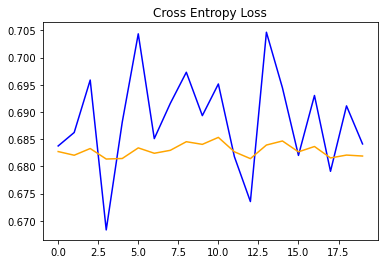

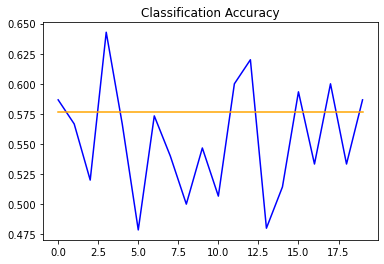

<Figure size 432x288 with 0 Axes>

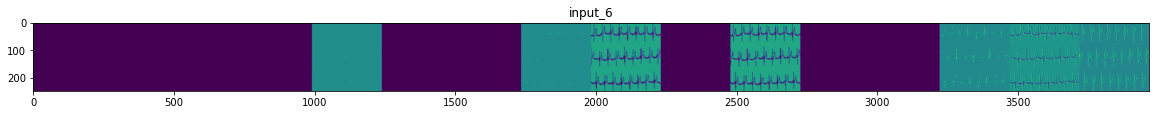

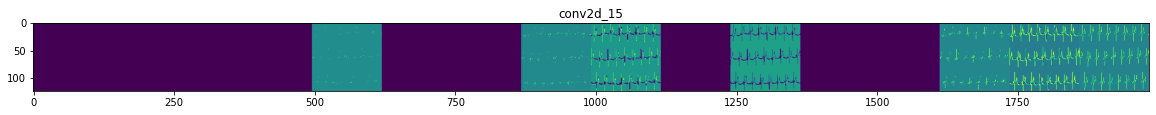

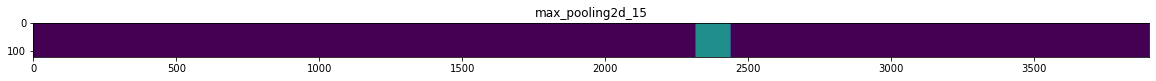

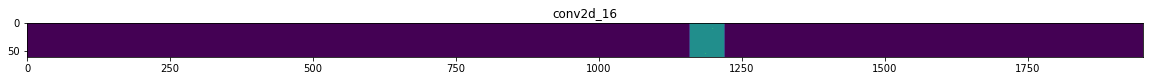

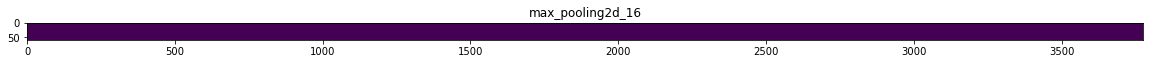

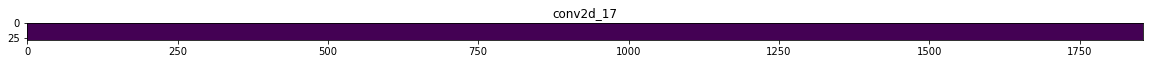

In [18]:

history = model.fit_generator(
      train_generator,
      steps_per_epoch=10,  # 2000 images = batch_size * steps
      epochs=20,
      validation_data=test_generator,
      validation_steps=10,  # 1000 images = batch_size * steps
      verbose=2)


#to save the trained modeL
model.save_weights("trainedcondrop3005_weights.h5")


# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
test_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
test_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

plt.subplot(111)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
plt.figure()
plt.subplot(111)
plt.title('Classification Accuracy')
plt.plot(history.history['acc'], color='blue', label='train')
plt.plot(history.history['val_acc'], color='orange', label='test')

plt.figure()


results = confusion_matrix 
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',history.history['acc'] )
print ('AReport : ')
print (history.history['val_acc']) 
print ('Loss Score :',history.history['loss'] )
print ('LReport : ')
print (history.history['val_loss']) 


model.load_weights("trainedcondrop3005_weights.h5")


# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
arritmia_img_files = [os.path.join(train_arritmia_dir, f) for f in train_arritmia_fnames]
normal_img_files = [os.path.join(train_normal_dir, f) for f in train_normal_fnames]
img_path = random.choice(arritmia_img_files + normal_img_files)

img = load_img(img_path, target_size=(250, 250))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')